In [1]:
import os
import glob
import csv
import sys
from pathlib import Path

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


from darts import TimeSeries
from darts.models import AutoARIMA
from darts.metrics import mae
from darts.utils.missing_values import fill_missing_values

import warnings

warnings.filterwarnings("ignore")
import logging

logging.disable(logging.CRITICAL)

In [3]:
from darts.dataprocessing.transformers import Scaler
from darts.metrics import mae
from darts.metrics import mse
from darts.metrics import rmse

In [4]:
os.getcwd()

'/home/nazim/MAIN4/projetindus2/Code/800-200'

In [5]:
!ls

darts_logs
Projet_bourse_200.ipynb
Projet_climat_200.ipynb
Projet_données_démographiques_200.ipynb
Projet_energie_gaz_eau_electricité_200.ipynb
Projet_maladies_200.ipynb
Sarima_bourse_200.ipynb
Sarima_climat_200.ipynb
Sarima_données_demographiques_200.ipynb
Sarima_energie_gaz_eau_electricité_200.ipynb
Sarima_maladies_200.ipynb
Transformers_bourse.ipynb
Transformers_climat.ipynb
Transformers_données_démographiques.ipynb
Transformers_energie_gaz_eau_electricité.ipynb
Transformers_maladies.ipynb


In [6]:
os.chdir('../../Datasets/Energies')
os.getcwd()

'/home/nazim/MAIN4/projetindus2/Datasets/Energies'

In [7]:
def interpolate_method(df,column_name,methode,direction,order,limit):
  df[column_name] = df[column_name].interpolate(method=methode,limit_direction = direction,order=order,limit=limit)
  return df

def clean_csv(df,time_variable,quantitative_variable):
  df = df[[time_variable, quantitative_variable]].copy()
  df.columns = ['ds','y']
  df['y'] = (df['y'].apply(pd.to_numeric, errors='coerce')).to_frame()
  df = df.drop_duplicates(subset=['ds'])
  df['ds'] = pd.to_datetime(df.ds, errors = 'coerce')
  df = df.dropna(subset=['ds'])
  df = df.sort_values(by=['ds'])
  pourcentage = ((len(df) - df['y'].count()) / len(df)) * 100
  if(pourcentage < 25):
    df = interpolate_method(df,'y',"polynomial",None,2,None)
  elif((pourcentage >= 25)):
    print("La base de donnée comporte un grand nombre de données manquantes pour être étudiée.")
  if(len(df) > 1000):
      supr = len(df) - 1000
      df = df[:-supr]
  return df, pourcentage

In [8]:
def simul():
    file_name = []
    df = []
    pourcentage = []

    series_scaled_list= []
    val_scaled_list = []
    pred_series_list= []
    error_results = pd.DataFrame(columns=['DATA_SET_NAME','MAE','MSE','RMSE'])
    i = 0
    
    for files in glob.glob("*.csv"):
        file_name.append(Path(files).stem)
        print(file_name[i])
        df_not_cleaned = pd.read_csv(files)
        df_clean, pourcentage_actual = clean_csv(df_not_cleaned, "Date","Value")
        df.append(df_clean)
        pourcentage.append(pourcentage_actual)

        series = TimeSeries.from_dataframe(df_clean, 'ds', 'y')

        train, val = series[:-200], series[-200:]

        scaler = Scaler()
        train_scaled = scaler.fit_transform(train)
        val_scaled = scaler.transform(val)
        series_scaled = scaler.transform(series)
        print("the {} dataset has {} data points".format(file_name[i],len(series)))
        
        series_scaled_list.append(series_scaled)
        val_scaled_list.append(val_scaled)
        
        model = AutoARIMA()
        model.fit(train_scaled)
        pred_series = model.predict(len(val))
        
        pred_series_list.append(pred_series)
        
        df_new_row_error = pd.DataFrame(data=np.array([[file_name[i],mae(pred_series, val_scaled), mse(pred_series, val_scaled), rmse(pred_series, val_scaled)]]), columns=['DATA_SET_NAME','MAE','MSE','RMSE'])
        error_results = pd.concat([error_results,df_new_row_error], ignore_index=True)
        i = i +1

    return file_name, df, series_scaled_list, val_scaled_list, pred_series_list, error_results

In [9]:
file_name, df, series_scaled_list, val_scaled_list, pred_series_list, error_results = simul()

D-spain_reservoir
the D-spain_reservoir dataset has 1000 data points
D_-_spain_fossilhardcoal
the D_-_spain_fossilhardcoal dataset has 1000 data points
D_-_spain_fossilbrowncoal
the D_-_spain_fossilbrowncoal dataset has 1000 data points
D-spain_river
the D-spain_river dataset has 1000 data points
D_-_spain_fossilgas
the D_-_spain_fossilgas dataset has 1000 data points
D-spain_wind_onshore
the D-spain_wind_onshore dataset has 1000 data points
D-spain_solar
the D-spain_solar dataset has 1000 data points
D-spain_other
the D-spain_other dataset has 1000 data points
D-spain_hydroconsump
the D-spain_hydroconsump dataset has 1000 data points
D-spain_other_ren
the D-spain_other_ren dataset has 1000 data points
D-spain_nuclear
the D-spain_nuclear dataset has 1000 data points
D_-_spain_biomass
the D_-_spain_biomass dataset has 1000 data points
D-spain_waste
the D-spain_waste dataset has 1000 data points
D_-_spain_fossiloil
the D_-_spain_fossiloil dataset has 1000 data points


In [10]:
error_results.to_csv(r'../../Resultats/Resultats_200/Sarima_results_energies.csv', index = False)

In [11]:
print(error_results)

                DATA_SET_NAME                  MAE                   MSE  \
0           D-spain_reservoir   0.0927997532697967  0.011794311431761234   
1    D_-_spain_fossilhardcoal  0.19580912804296102   0.05282033061608875   
2   D_-_spain_fossilbrowncoal  0.26249413976985436   0.10933644048774113   
3               D-spain_river  0.16682596378473144  0.035767428660667094   
4         D_-_spain_fossilgas  0.17523698080276107    0.0466755803888811   
5        D-spain_wind_onshore  0.14163365974794526  0.029945655633860577   
6               D-spain_solar   0.2650886637623323   0.08948243802182482   
7               D-spain_other  0.13094573631219444   0.04749076770854149   
8        D-spain_hydroconsump  0.14336342084526993  0.030481374214869385   
9           D-spain_other_ren  0.13101968731205477  0.026136188171095958   
10            D-spain_nuclear  0.14833329730800998  0.027433502307269646   
11          D_-_spain_biomass  0.11190182615333183  0.020853325875420846   
12          

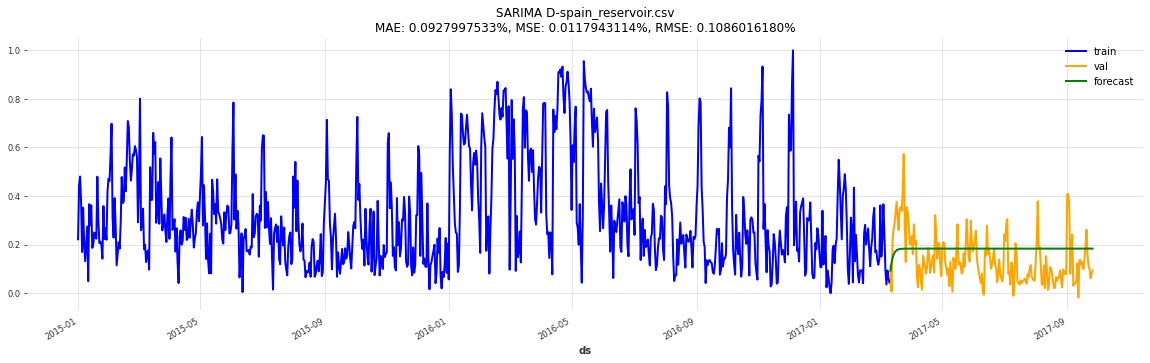

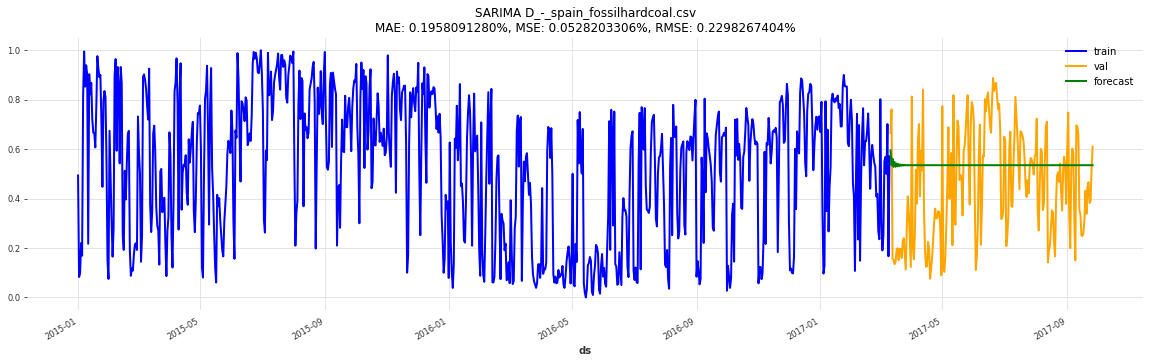

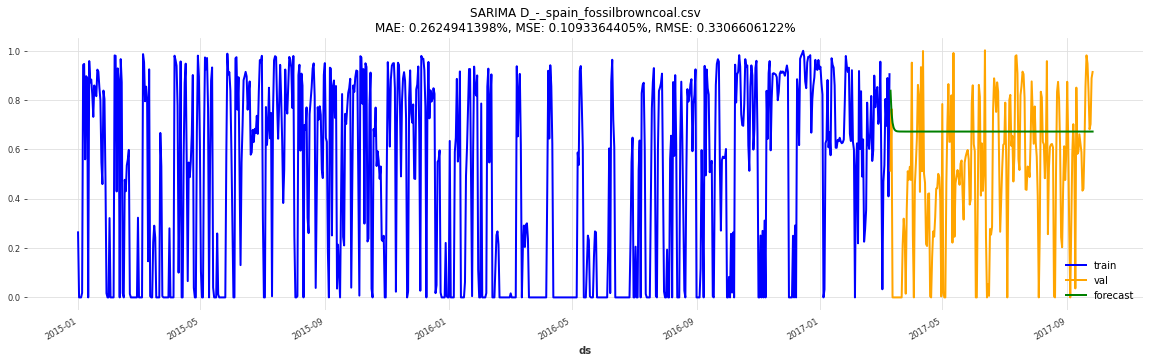

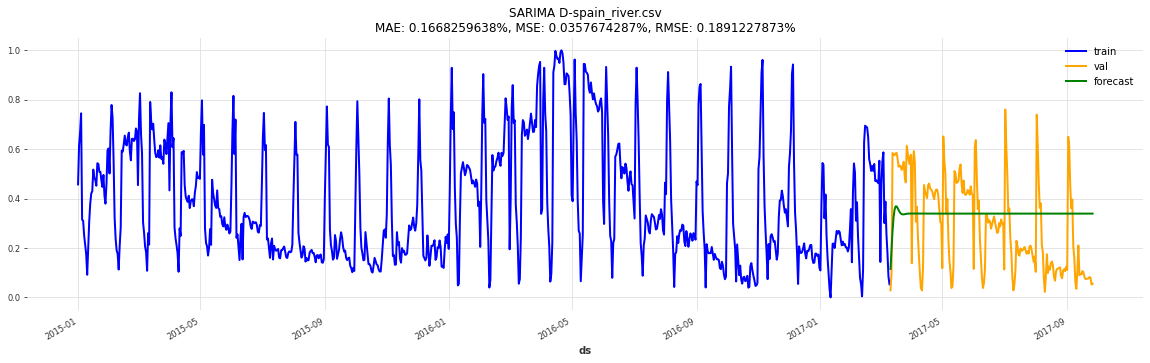

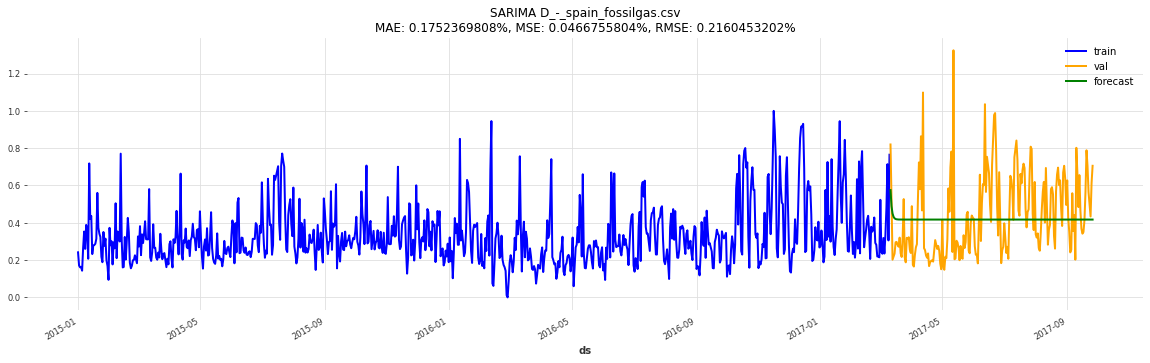

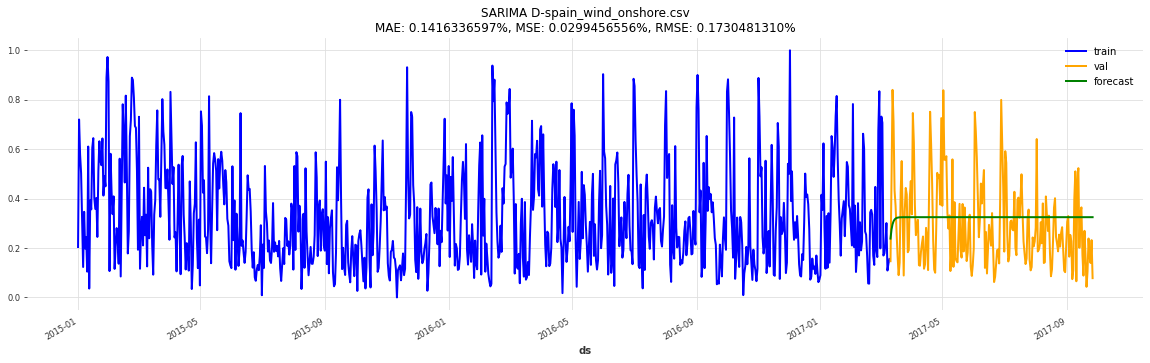

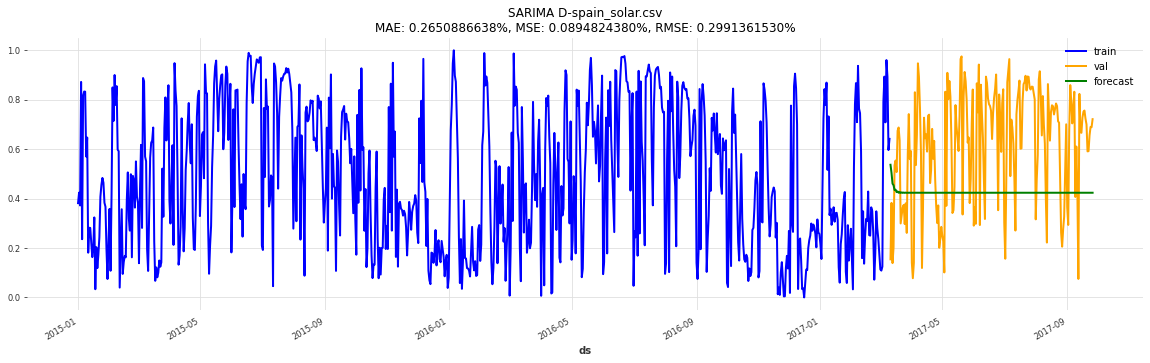

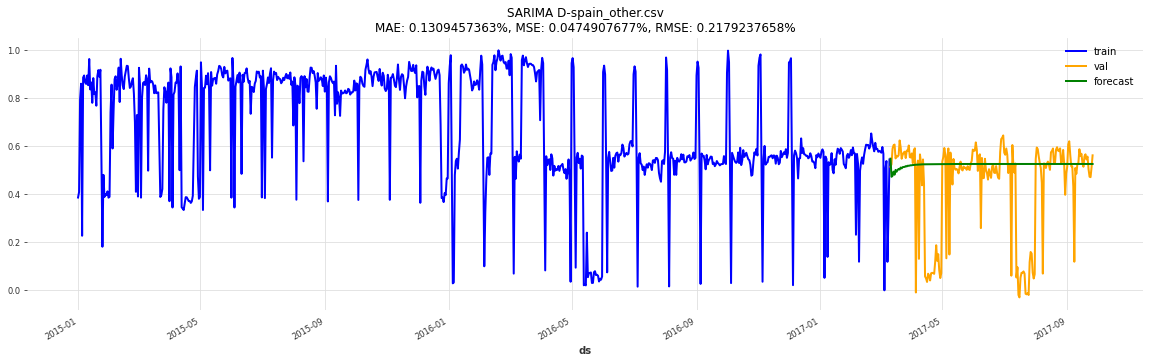

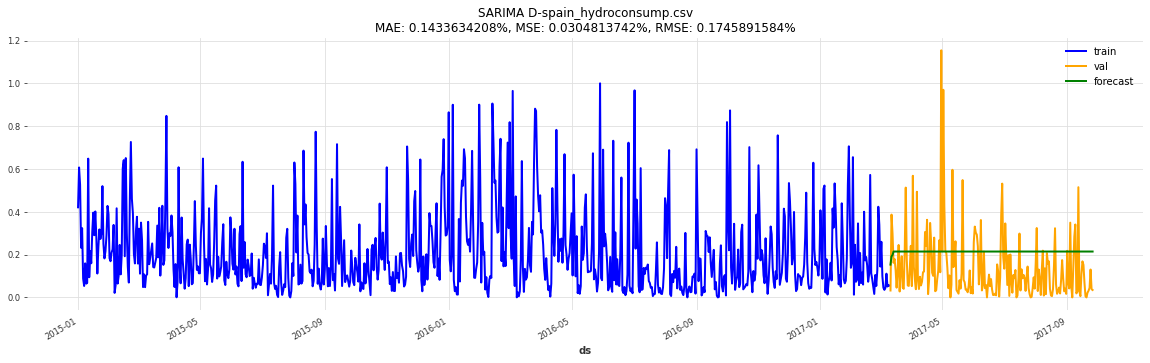

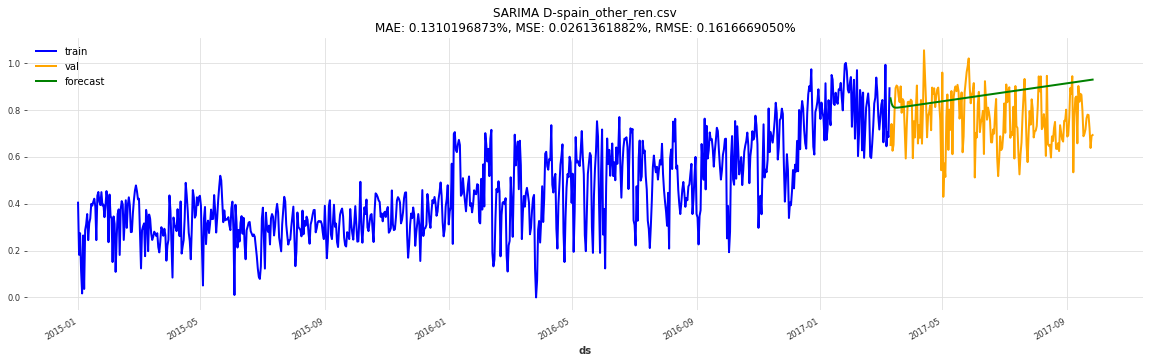

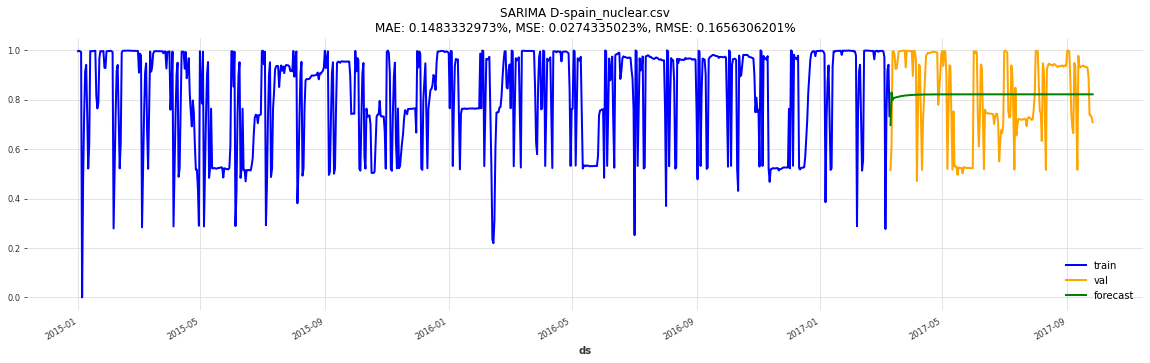

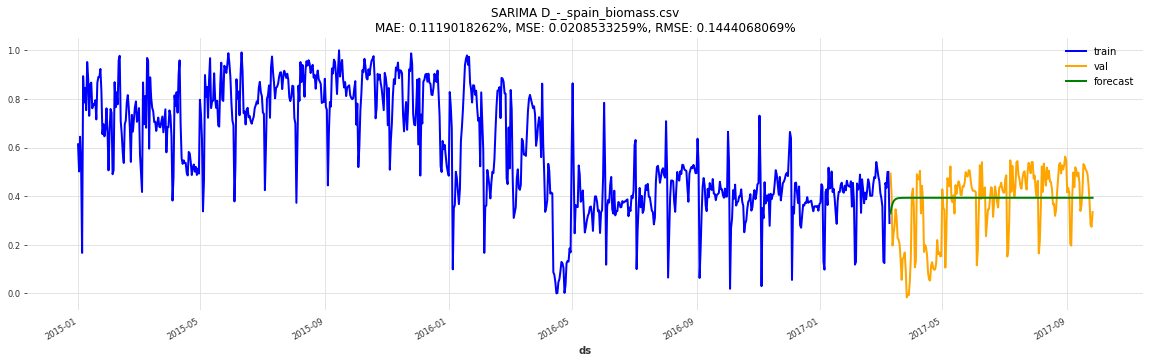

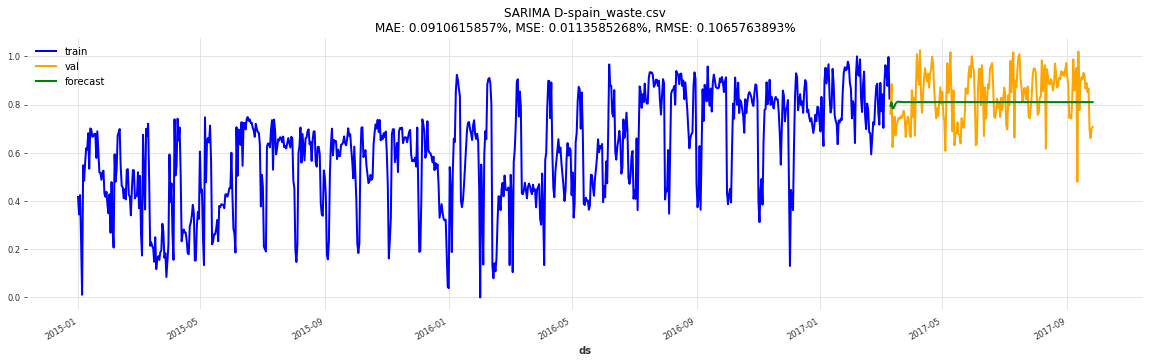

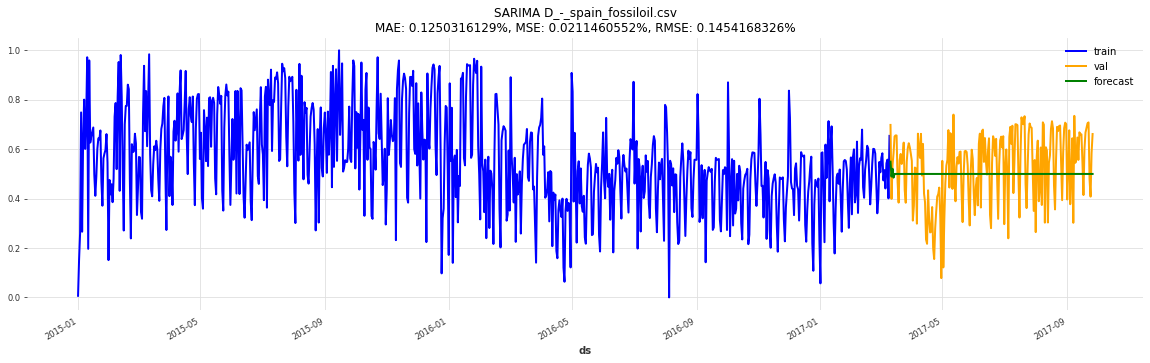

In [12]:
for i in range(len(df)):
    plt.figure(figsize=(20,5))
    train, val = series_scaled_list[i][:-200], series_scaled_list[i][-200:]
    train.plot(color ='blue', label="train")
    val.plot(color ='orange', label="val")
    pred_series_list[i].plot(color ='green',label="forecast")
    plt.title('SARIMA {}.csv\nMAE: {:.10f}%, MSE: {:.10f}%, RMSE: {:.10f}%'.format(file_name[i],mae(pred_series_list[i], val_scaled_list[i]), mse(pred_series_list[i], val_scaled_list[i]), rmse(pred_series_list[i], val_scaled_list[i])))
    plt.legend(loc='best')
    plt.show()